# Physical scene understanding lab

This lab introduces concepts and tools for building probabilistic models of intuitive physics. It focuses on inferring physical object properties (mass, bounciness) from sequentially observed video input.

<div class="alert alert-info" markdown="1">
    <strong> Note on installing necessary packages </strong>

We installed `pybullet` (see below for what it is) using `Conda.jl`. This is for your reference if you wish to install on your local environment. If this is the first time running the notebook, set `INSTALL` to `true`.
    
</div>



In [1]:
INSTALL = false;

In [2]:
# Installing pybullet python dependency - part of the forward model
if INSTALL
    using Pkg
    Pkg.activate("lab06")
    using Conda
    run(`conda config --set pip_interop_enabled true`)
    run(`pip install pybullet`)
    # Adding additional Julia dependencies
    Pkg.add(url="https://github.com/CNCLgithub/PhySMC.git");
    Pkg.add(url="https://github.com/CNCLgithub/PhyBullet.git");
    Pkg.add("PyCall");
    Pkg.add("Accessors");
    Pkg.add("Distributions");
    Pkg.add("Gen");
    Pkg.add("Plots");
end

In [3]:
# Load project
using Pkg
Pkg.activate("lab06")

  Activating project at `~/Algorithms-of-the-Mind/labs/lab-06/lab06`


## Part 0: Setup for this lab

Since this lab uses some extra dependencies, please make sure to follow these instructions carefully. 

We will use [pybullet](https://pybullet.org/wordpress/), a real time physics engine, under the hood to create physics-based temporal generative models.The `PyCall` package should take care of this for you in `pyimport`. 

In [4]:
using PyCall
pb = pyimport("pybullet")

pybullet build time: Jan 29 2025 23:17:20


PyObject <module 'pybullet' from '/home/psyc2610_meb266/.local/lib/python3.11/site-packages/pybullet.cpython-311-x86_64-linux-gnu.so'>

### First time installations

With this, we can install several Julia packages. `PhySMC` and `PhyBullet`, which are form the CNCL github repo, provide functionality for inference over physical scenes. 

In [5]:
using Gen;
using PhySMC;
using PhyBullet;
# the following package allows us to more nicely/easily update contents of 
# structs that contain object state information
using Accessors; 
using Distributions;
# For some visualizations
using Plots;

# Visual inference using a physics-based generative model

This lab introduces a computational model that infers "physics-based representations" of scenes; in other words, the model explains visual inputs in terms of their underlying physical causes. To implement these structure-preserving representations of physical scenes, we build on the idea of a "physics engine in the mind" (introduced, in large part, by [Battaglia et al. (2013)](https://www.pnas.org/doi/pdf/10.1073/pnas.1306572110)), which refers to a general schema where the mind might use runnable mental models, akin to a physics simulator in a video game engine. One way to make this idea concrete (i.e., implement in empirically testable computational models) is to embed off-the-shelf physics engines in probabilistic models. 

Here, we explore an implementation that uses the probabilistic programming package `Gen` and the physics engine `pybullet`. We will build a generative model that defines a probability distribution over the trajectories of a ball, conditioned on the ball's [coefficient of restitution (or, bounciness)](https://en.wikipedia.org/wiki/Coefficient_of_restitution) and mass. We will also explore approximate Bayesian inference procedures, such as [particle filters](https://en.wikipedia.org/wiki/Particle_filter) that leverage the sequential nature of the underlying generative model to efficiently update physics-based representations. 

Specifically, we will observe (i.e., take as input) a sequence of the positions of a falling and bouncing ball, and based on that, infer its bounciness and mass.

## The software tools

Before we start, here is an overview of the software tools that we will be using to build our model.

- [Gen](https://www.gen.dev/): An open-source stack for generative modeling and probabilistic inference. (Think of Gen as what pytorch is for deep learning.)
- [bullet3 physics engine](https://github.com/bulletphysics/bullet3) via [pybullet](https://pypi.org/project/pybullet/): real-time collision detection and multi-physics simulation for VR, games, visual effects, robotics, machine learning etc.
- [PhySMC](https://github.com/CNCLgithub/PhySMC) and [PhyBullet](https://github.com/CNCLgithub/PhyBullet): two companion packages that provide appropriate abstractions to integrate off-the-shelf physics simulation (such as pybullet) into probablistic programming. Feel free to read the ReadMe of these packages.

## The Physical scenario: Bouncing balls

To make the model concrete in a physical scenario, all we need to do is to initialize a scene configuration, which can then be simulated forward.

Here, we will work with a simple initial scene configuration: a table and a ball above its center.

Below is the implementation of `simple_scene`, a helper function that will do just that. You do not need to familiarize yourself with or understand the expressions in `simple_scene`, but please feel free to look if you are curious (by toggling the visibility of the next code block). Most of the commands in it invoke the `pybullet` API.

In [6]:
"""
	simple_scene(mass=1.0, restitution=0.9) -> Tuple(client, ball)

Initializes a simple scene with a ball over a table.
"""
function simple_scene(mass::Float64=1.0, restitution::Float64=0.9)
    # `pb` is the `pybullet` python package
    # initialize a physics server in pybullet
    client = @pycall pb.connect(pb.DIRECT)::Int64
    # gotta set the gravity
    pb.setGravity(0,0,-10; physicsClientId=client)

    # add a table
    dims = [1.0, 1.0, 0.1] # in meters
    col_id = pb.createCollisionShape(pb.GEOM_BOX,
                                     halfExtents=dims,
                                     physicsClientId=client)
    obj_id = pb.createMultiBody(baseCollisionShapeIndex=col_id,
                                basePosition=[0., 0., -0.1],
                                physicsClientId=client)
    pb.changeDynamics(obj_id,
                      -1;
                      mass=0., # 0 mass means this object does not move (it's stationary)
                      restitution=0.9, # some is necessary; we could learn or infer this parameter
                      physicsClientId=client)


    # add a ball
    bcol_id = pb.createCollisionShape(pb.GEOM_SPHERE,
                                      radius=0.1,
                                      physicsClientId=client)
    bobj_id = pb.createMultiBody(baseCollisionShapeIndex=bcol_id,
                                 basePosition=[0., 0., 1.0],
                                 physicsClientId=client)
    pb.changeDynamics(bobj_id,
                      -1;
                      mass=mass,
                      restitution=restitution,
                      physicsClientId=client)

    (client, bobj_id)
end

simple_scene

In [7]:
client, ball_id = simple_scene()

(0, 1)

Once initialized, a scene configuration can be simulated forward in time using the physics engine.

The following three data structures, which are part of the PhySMC and PhyBullet packages, will help us keep track of the simulation for probabilistic inference: 

- `BulletSim` : Parameters for using the Bullet physics engine (implemented in PhySMC)
- `RigidBody` : A rigid body in BulletSim (implemented in PhyBullet)
- `BulletState`: State for BulletSim, including that of the RigidBody (implemented in PhySMC)

Feel free to inspect their docstrings for more info.


<div class="alert alert-info" markdown="1">
    <strong> Note: </strong>

at any point during this tutorial you can find more info about an element by either typing `?` before the name, using  `@doc NAME`. 
    
</div>
 

We first instantiate the simulator data structure (`BulletSim`) with the client id provided by pybullet.

In [8]:
# configure simulator with the provided
# client id
sim = BulletSim(; client=client)

BulletSim
  client: Int64 0
  step_dur: Float64 0.016666666666666666
  pb_timestep: Float64 0.004166666666666667


In [9]:
# This is the object of interest in the scene
# (the table is static)
ball = RigidBody(ball_id)

RigidBody(1)

In [10]:
# Retrieve the default latents for the ball
# as well as its initial positions
# Note: we will override these latents using the `prior`
init_state = BulletState(sim, [ball])

BulletState(BulletElement[RigidBody(1)], BulletElemLatents[RigidBodyLatents((mass = 1.0, lateralFriction = 0.5, restitution = 0.9, rollingFriction = 0.0, spinningFriction = 0.0, contactDamping = -1.0, contactStiffness = -1.0, collisionMargin = 0.1))], BulletElemState[RigidBodyState([0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], StaticArraysCore.SVector{3, Float64}[[-0.1, -0.1, 0.9], [0.1, 0.1, 1.1]])])

We will use the helper function `simulate_scene` to advance the simulation forward. 

In [12]:
"""
	simulate_scene(init_state, t) -> [BulletState]

Runs physics for `t` steps returning a `Vector` of `t+1` states.
"""
function simulate_scene(init_state::BulletState, steps::Int=60)
	states = Vector{BulletState}(undef, steps+1)
	states[1] = init_state
	for i = 2:(steps+1)
		# Use PhySMC and PhyBullet to simulate a step
		states[i] = PhySMC.step(sim, states[i-1])
	end
	return states
end;

Let's run the simulation for 60 time steps.

In [13]:
# Simulating 60 steps.
states = simulate_scene(init_state, 60);

With some animation functions, let's take a look at the timecourse of the bouncing ball. 
Here, we are visualizing the height of the ball (y-axis) as a function of time (x-axis)

In [15]:
# Many of the following commands are defined in Plots.jl
# You do not need to fully understand the.
# Essentially this plots a time series of positions
@userplot SimPlot
@recipe function f(cp::SimPlot)
    z, t = cp.args
    cs = size(z, 1)
    k = 10
    inds = (max(1, t-k):t)
    n = length(inds)
    linewidth --> range(0, 10, length = n)
    seriesalpha --> range(0, 1, length = n)
    xguide --> "time"
    yguide --> "height of ball (z)"
    ylims --> (0, 1.0)
    xlims --> (1, 60)
    label --> false
    inds, z[inds, :]
end
function get_zs(states::Vector)
    t = length(states)
    zs = Vector{Float64}(undef, t)
    for i = 1:t
        zs[i] = states[i].kinematics[1].position[3]
    end
    return zs
end
function animate_trace(trace::Vector; label = "trace")
    t = length(trace)
    zs = reshape(get_zs(trace), (t, 1))
    anim = @animate for i = 2:t
        simplot(zs, i, label = label)
    end
end;

[ Info: Saved animation to /home/psyc2610_meb266/Algorithms-of-the-Mind/labs/lab-06/tmp.gif


Plots.AnimatedGif("/home/psyc2610_meb266/Algorithms-of-the-Mind/labs/lab-06/tmp.gif")
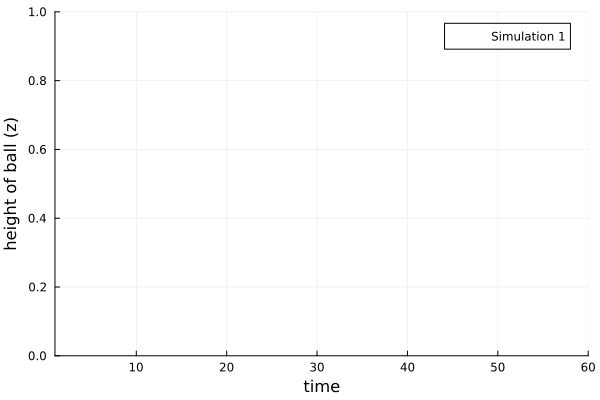

In [16]:
anim = animate_trace(states; label="Simulation 1");
gif(anim, fps = 24)

Now compare that scene to the one below: What *jumps* out? 

[ Info: Saved animation to /home/psyc2610_meb266/Algorithms-of-the-Mind/labs/lab-06/tmp.gif


Plots.AnimatedGif("/home/psyc2610_meb266/Algorithms-of-the-Mind/labs/lab-06/tmp.gif")
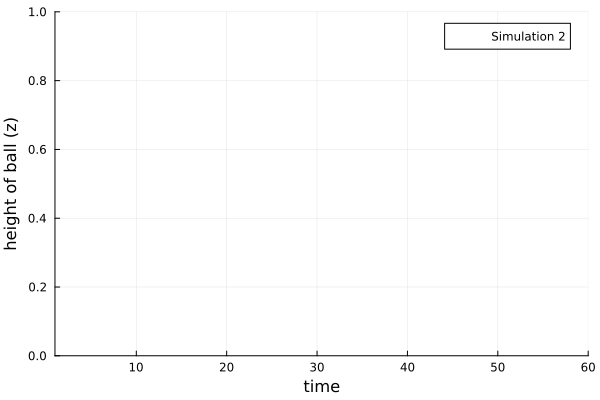

In [17]:
client2, ball_id2 = simple_scene(1.0, 0.5)
ball2 = RigidBody(ball_id2)
sim2 = BulletSim(; client=client2)
init_state2 = BulletState(sim2, [ball2])
states2 = simulate_scene(init_state2, 60)
anim2 = animate_trace(states2; label="Simulation 2")
gif(anim2, fps = 24)

We clearly see a difference in their trajectories --- the different heights each ball reaches. But, it is also possible that we just as well see a much higher property --- what has caused these two different trajectories: The different physical properties, i.e., bounciness, of each ball. You can almost *hear* the distinct sound each collision would make on the table. 

Our goal in this notebook is to implement a psychologically plausible algorithm that can model such human perception of physical properties. We'll do so using probabilistic modeling.

We will accomplish this in two parts:

1. Specify a generative model: the conditional distributions over how objects move and appear
2. Implementing a psychologically plausible inference algorithm that updates the states and latents of objects given a sequence of observations

## Part 1: The Physical Generative Model

The generative model (`model`) takes as input the initial scene configuration (a ball positioned above a stable table), and defines conditional distributions over how objects move (uses the [bullet3 physics engine](https://github.com/bulletphysics/bullet3)) and appear, producing a sequence of predictions about the object state across time. 

The following diagram illustrates these conditional relationships.

![physical markov chain](https://raw.githubusercontent.com/CNCLgithub/AlgorithmsOfVisionCCN2025/refs/heads/bouncing_ball/physics_chain.svg)

More formally, this generative model [i.e., a joint distribution over latent variables (i.e., objects' physical properties) and observations (i.e., sensory measurements)] can be defined in the following mathematical expression: 

$$
Pr(\vec{S}, \vec{X}) = Pr(S_0) \prod\limits_{t=1}^{T} Pr(X_t \mid S_t) \cdot Pr(S_t \mid S_{t-1})
$$

This generative model is factorized into three conditional probability distributions, each of which will be implemented using a `Gen` generative function (more on that below):

1. `prior`: $Pr(S_0)$ samples new latents from a prior distribution. In our example, this consists of prior distributions over the latent variables mass and bounciness of the ball.
2. `observe`: $Pr(X_t \mid S_t)$ generates noisy observations over object positions (in $\mathcal{R}^3$) for a given scene configuration.
3. `kernel`: $Pr(S_t \mid S_{t-1})$ simulates T steps into the future, generating scene configurations for each step.

Let's see how this generative model can be implemented using the general-purpose probabilistic programming package Gen.


### The prior over latent variables (i.e., an object's physical properties), $Pr(S_0)$

The `prior` defines a distribution over what the physical properties of an object *should* be. For the purposes of this tutorial, the prior will implement only two object properties: mass and bounciness (assigning the rest deterministically).

The value of this prior will be stored in a new data structure called `RigidBodyLatents`. See below for a docstring that provides a more thorough description of `RigidBodyLatents`, which consists of both the latents we define a prior distribution over (mass and bounciness) and several others.

In [18]:
@doc RigidBodyLatents

Latents for `RigidBody`

```julia
struct RigidBodyLatents <: BulletElemLatents{RigidBody}
```

Any collection of property values can be declared in `data`. Most commonly these will properties such as "mass" or "lateralFriction" and any undeclared properties will use default values (see pybullet)

A non-exhaustive list of properties

  * mass
  * lateralFriction
  * localInertiaDiagonal
  * localInertialPos
  * localInertialOrn
  * restitution
  * rollingFriction
  * spinningFriction
  * contactDamping
  * contactStiffness

---

  * `data::NamedTuple`


We manipulate the values of these latent variables using the helper function `update_latents`.

In [19]:
"""
	update_latents(latents, mass, restitution) -> RigidBodyLatents

A helper function to update the state contained in a struct called RigidBodyLatents.
Notice that RigidBodyLatents contains all of the latent variables that we wish to make inferences about
"""
function update_latents(ls::RigidBodyLatents, mass::Float64, res::Float64)
    RigidBodyLatents(setproperties(ls.data;
                           mass=mass,
                           restitution=res))
end;

Now with this new data structure, we are ready to define this prior distribution over the mass and bounciness of a ball (that'll, in a bit, fall from a height and bounce on a stable table) using `Gen`.

In [20]:
"""
	prior(template) -> RigidBodyLatents

The prior. Samples mass and restitution given a template set of other latent variables.
"""
@gen function prior(ls::RigidBodyLatents)
    mass ~ gamma(1.2, 10.)
    restitution ~ uniform(0, 1)
    new_latents = update_latents(ls, mass, restitution)
    return new_latents
end;

Notice that the `prior` is a special kind of function: it's a generative function (indicated by the macro `@gen` that precedes its definition) whose evaluations are stochastic, resulting in different values each time it's run. We'll experience this in a moment.

Specifically, this generative function defines mass as distributed with a [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) (example below) and restitution as coming from a uniform distribution (between the values 0 and 1).


<div style="background-color: white;">
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5e/Gammapdf252.svg?download" alt="Example of gamma distribution (credit Wikipedia)">
</div>

(Note: Here is a helpful [tool](https://distribution-explorer.github.io/) for exploring probability distributions.)

Now let's call the function `prior` to draw samples from it.

As mentioned above, notice how each time you evaluate this function, you get a different set of values. Under the hood, each evaluation of such generative functions creates a Gen "trace", which tracks every stochastic decision made during execution. (In this tutorial, we will not go into the details of the "trace" data structure, but it's the key data structure that enables performant, general-purpose probabilistic inference in Gen.)  

In [21]:
prior(RigidBodyLatents((mass = 0.5, restitution=0.5)))

RigidBodyLatents((mass = 0.29151775419989673, restitution = 0.9261807386183792))

(As a technical note, when calling the `prior` function, we pass in a template `RigidBodyLatents` data structure to define any latents we do not want changed. Only the mass and restitution are overwritten by the `prior` function.)

### The likelihood: How well does a state explain an observation, $Pr(X_t \mid S_t)$

Recall that the generative model takes as input an initial scene configuration. At each time step, the physical properties of an object cause changes to this scene configuration. For example, the ball moves under the influence of gravity at each time step. 

Let's define both the scene configuration, the observation space, and how they relate.

For each time step, the scene configuration consists of the 3D positions, orientations, and velocities of objects.

In [22]:
@doc RigidBodyState

State for `RigidBody`

```julia
struct RigidBodyState <: BulletElemState{RigidBody}
```

---

  * `position::StaticArraysCore.SVector{3, Float64}`: XYZ position
  * `orientation::StaticArraysCore.SVector{4, Float64}`: Quaternion xyzw
  * `linear_vel::StaticArraysCore.SVector{3, Float64}`: Linear velocity XYZ
  * `angular_vel::StaticArraysCore.SVector{3, Float64}`: Angular velocity wX wY wZ
  * `aabb::StaticArraysCore.SVector{2, StaticArraysCore.SVector{3, Float64}}`: Axis-aligned Bounding box


In [23]:
@doc raw"""
	observe(state) -> XYZ

Defines a conditional distribution over the object's 3D position with ``\sigma=0.1``
"""
@gen function observe(state::RigidBodyState)
    position ~ broadcasted_normal(state.position, 0.1)
    return position
end;

Like `prior`, notice that the `observe` function is also a generative function (indicated by the preceding `@gen` macro), meaning that its executions are stochastic and Gen keeps track of all the stochastic decisions under the hood.

#### A note about the observation space

You might be thinking that this is a contrived observation space - and we agree! The `observe` generative function can readily incorporate pixel-based (or other sensor computable) observation spaces. However, using them in this demo would incur unnecessary technical complications (e.g., need for gpus).  

Instead, below, we provide some code from real projects that use such sensor-computable observation spaces. 

---


From [Woven](https://github.com/CNCLgithub/Woven/blob/82cfcfd7b9f51899df4f0cdcf2ae18dae466d38a/src/model/generative_model.jl#L158-L161) as published in: Computational models reveal that intuitive physics underlies visual processing of soft objects, Bi et al., 2025, Nature Communications

---

From [GranularScenes](https://github.com/CNCLgithub/GranularScenes/blob/7bb9dd9809c1c72d1be320909746df0aa8581c9f/src/gm/qt_model_gen.jl#L35-L47), Goal-conditioned world models: adaptive computation over multi-granular generative models explains human scene perception, Belledonne & Yildirim, manuscript in prep.

```julia
@gen function qt_model(t::Int, params::QuadTreeModel)
    # sample quad tree
    root::QTAggNode = {:trackers} ~ quad_tree_prior(params.start_node, 1)
    qt::QuadTree = QuadTree(root)

    # first image (X_0)
    {:img_a} ~ observe_pixels(params.renderer, qt, params.pixel_var)

    # second image (X_1) (could be the same image)
    changes ~ Gen.Unfold(qt_change_kernel)(t, qt, params)

    return qt
end
```

---

From [ThreeDP3](https://github.com/probcomp/ThreeDP3/blob/main/src/model/sg_model.jl#L188-L201), as published in 3DP3: 3D scene perception via probabilistic programming, Gothoskar et al., 2021, NeurIPS
```julia
@gen (static) function scene(model_params::SceneModelParameters)
    scene_graph ~ scene_graph_prior(model_params)
    rendered_clouds = render_clouds(model_params, scene_graph)
    p_outlier ~ exponential(1/model_params.hyperparams.p_outlier)
    noise ~ exponential(1/model_params.hyperparams.noise)
    obs_cloud = {:obs} ~ uniform_mixture_from_template_multi_cloud(
                                                rendered_clouds,
                                                p_outlier,
                                                noise,
                                                (-100.0,100.0,-100.0,100.0,-100.0,300.0))
    return (scene_graph=scene_graph,
            rendered_clouds=rendered_clouds,
            obs_cloud=obs_cloud)
end
```

---

### The kernel: how objects move, $Pr(S_t \mid S_{t-1})$


Now let's move to the kernel below, it's only a couple of lines. 

In [24]:
@doc raw"""

	kernel(t, prev_state, simulator) -> next_state

Advances the physical scene by one timestep and samples observations for that new state.
"""
@gen function kernel(t::Int, prev_state::BulletState, sim::BulletSim)
    # use of PhySMC.step to step the simulation forward one time step
    next_state::BulletState = PhySMC.step(sim, prev_state)
    # `next_state.kinematics = [RigidBodyState]` G
    positions ~ Gen.Map(observe)(next_state.kinematics)
    return next_state
end;

Notice that the kernel makes a call to the physics engine to step the simulation one time step forward, using PhySMC.step(...). This implements temporal dynamics in the generative model, the horizontal arrow from the figure above.

The return value of this call, next_state is a scene configuration (position, velocity, orientation) of a rigid body (i.e., the object we are simulating). (Such non-dynamical scene configuration information is also called the kinematics state.)

### The full generative model: $Pr(S_0) \prod\limits_{t=1}^{T} Pr(X_t \mid S_t) \cdot Pr(S_t \mid S_{t-1})$

Now we have all three pieces needed to build the full generative model. Let's take a look below.

In [25]:
@doc raw"""
	model(t, simulator, template_state) -> [RigidBodyStates]

Samples an initial set of latents from the `prior` and then simulates for `t` steps, using `kernel`.
"""
@gen function model(T::Int, sim::BulletSim, template::BulletState)
    # distribution over mass and restitution for objects from the prior
    latents ~ Gen.Map(prior)(template.latents)
    init_state = Accessors.setproperties(template; latents=latents)
    # simulate `T` timesteps; kind of like a cool for-loop
    states ~ Gen.Unfold(kernel)(T, init_state, sim)
    return states
end;

Ok, with the model ready, I bet you are itching to run some samples! First, we will need to prepare the simulation environment and a template scene.

In [26]:
# arguments for `model`
gargs = (60, # number of steps (total duration 1s)
         sim,
         init_state);

Ok, we are now ready to run the model forward for 60 steps!

We will use the `Gen.generate()` function to do so. This function takes as input a generative function (here: `model`) and its arguments (here: `gargs`), and returns a trace of the execution of this generative function (a record of all the stochastic decisions made during the call of the generative function).

In [27]:
trace, _ = Gen.generate(model, gargs);

Well that was somewhat anti-climactic. Let's use this nifty plotting function to visualize our simulation!

In [28]:
function get_zs(trace::Gen.Trace)
    t, _... = get_args(trace)
    states = get_retval(trace)
    zs = Vector{Float64}(undef, t)
    for i = 1:t
        zs[i] = states[i].kinematics[1].position[3]
    end
    return zs
end
function animate_trace(trace::Gen.Trace; label = "trace")
    t = first(get_args(trace))
    zs = reshape(get_zs(trace), (t, 1))
    anim = @animate for i = 2:t
        simplot(zs, i, label = label)
    end
end

animate_trace (generic function with 2 methods)

[ Info: Saved animation to /home/psyc2610_meb266/Algorithms-of-the-Mind/labs/lab-06/tmp.gif


Plots.AnimatedGif("/home/psyc2610_meb266/Algorithms-of-the-Mind/labs/lab-06/tmp.gif")
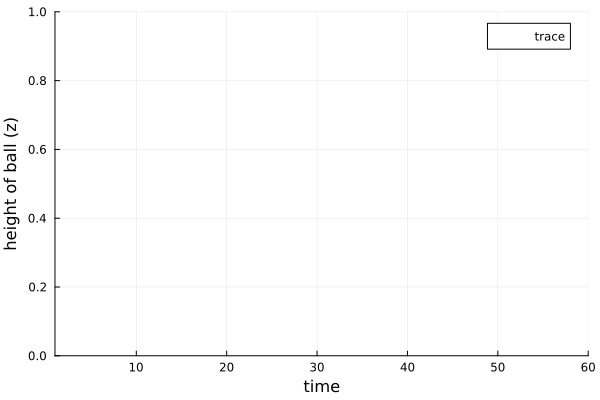

In [29]:
gif(animate_trace(trace), fps = 24)

That's neat! We can see the ball bouncing around - and how much it bounces should depend on the restitution you sampled. 

By repeatedly running `generate` on `model`, we draw different samples from our generative model, which are stored in `trace`. Here, we visualize the traces of a range of physical properties for the ball and see how each leads to a different timecourse.

[ Info: Saved animation to /home/psyc2610_meb266/Algorithms-of-the-Mind/labs/lab-06/tmp.gif


Plots.AnimatedGif("/home/psyc2610_meb266/Algorithms-of-the-Mind/labs/lab-06/tmp.gif")
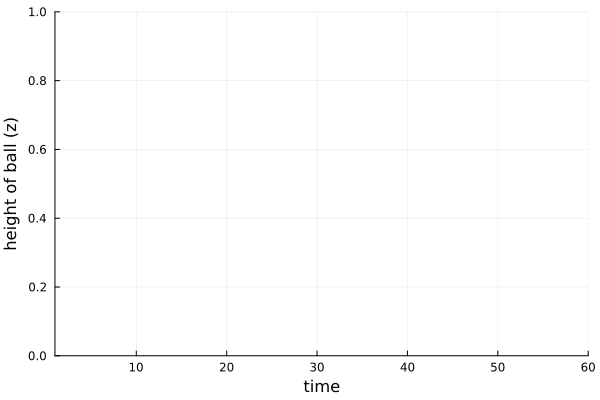

In [30]:
traces = [first(Gen.generate(model, gargs)) for _=1:7];

function animate_traces(traces::Vector{<:Gen.Trace})
    n = length(traces)
    zzs = reduce(hcat, map(get_zs, traces))
    t = size(zzs, 1)
    anim = @animate for i=2:t
        simplot(zzs, i)
    end
end

gif(animate_traces(traces), fps=24)

## Part 2: Inference Over Dynamic Scenes, $Pr(\vec{S} \mid \vec{X})$

Let's return to the main question: How can we infer the physical latents of the scene given a sequence of observations?

So far, we implemented a generative model, which is the joint distribution $Pr(\vec{S}, \vec{X})$.

Now by the [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes'_theorem), we can condition this generative model on observations to get an approximation of the posterior $Pr(\vec{S} \mid \vec{X})$.

Let's look at our first simulation and extract noisy positions. These will serve as our observations, $\vec{X}$. Take note of the ground truth latents for mass and restitution (1.0 and 0.8, respectively)- we will ultimately want to compare the inferences of our model (the posterior over physical properties, $Pr(\vec{S}|\vec{X})$) to these values.

[ Info: Saved animation to /home/psyc2610_meb266/Algorithms-of-the-Mind/labs/lab-06/tmp.gif


Plots.AnimatedGif("/home/psyc2610_meb266/Algorithms-of-the-Mind/labs/lab-06/tmp.gif")
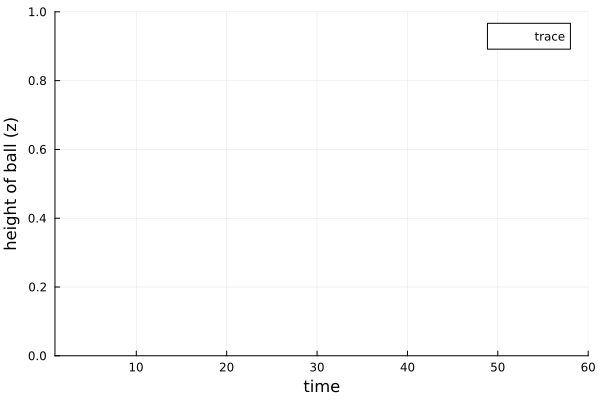

In [31]:
# First, let's generate a scene with a specific mass and restitution 
# Our goal is to generate a simulated observation that we can work with
gt_latents = choicemap(
    (:latents => 1 => :restitution, 0.8), 
    (:latents => 1 => :mass, 1.0)
)
gt = first(generate(model, gargs, gt_latents));
gt_choices = get_choices(gt)

t = gargs[1]

# one set of observations per time step
# (notice that these do not contain gt latents)
observations = Vector{Gen.ChoiceMap}(undef, t)
for i = 1:t
    cm = choicemap()
    addr = :states => i => :positions
    set_submap!(cm, addr, get_submap(gt_choices, addr))
    observations[i] = cm
end

gif(animate_trace(gt), fps=24)

## The inference procedure - A particle filter

Now there are many inference procedures we could use to arrive at this posterior, $Pr(\vec{S}|\vec{X})$. A standard work-horse in Bayesian inference is the [Metropolis-Hastings Markov Chain Monte-Carlo algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm). However, this algorithm is not particularly desirable in this case, as it requires all observations to be received simultaneously, instead of receiving them sequentially. 

A far more natural (but by no means perfect) algorithm is the [particle filter](https://www.stats.ox.ac.uk/~doucet/smc_resources.html), which excels at posteriors that can be factorized sequentially. 

Indeed, our physical setting factorizes along time:

```math
Pr(\vec{S} \mid \vec{X}) \propto Pr(S_0) \cdot \prod\limits_{t=1}^{T} Pr(S_t \mid X_t) \cdot Pr(S_t \mid S_{t-1})
```


Each particle in a particle filtering algorithm is an independent trace of the generative model, conditioned on the observations received so far. Together, these particles form a non-parametric approximation of the posterior over the object's physical properties.

For each incoming observation (i.e., at each time step), the particle filter has three steps:

![Particle filter diagram](https://raw.githubusercontent.com/CNCLgithub/AlgorithmsOfVisionCCN2025/refs/heads/bouncing_ball/particle_filter.svg)

1. **Update**: each particle samples (via `kernel`) the next state of the scene, $S_{t+1}$, weighting both the prior probability of that transition $Pr(S_{t+1} \mid S_t)$ as well as the likelihood $Pr(X_{t+1} \mid S_{t+1})$. 
2. **Resample**: A genetic-like pruning procedure, where particles are drawn, with replacement, from a multinomial distribution based on the normalized log-scores from step 1.
3. **Rejuvenation**: Each surviving particle receives a series of probabilistic adjustments to object latents using a `proposal` function. This procedure keeps each adjustment with a probability proportional to how likely it's under the `proposal` function and how much it improves the current likelihood of the observation (aka the [Metropolis-Hastings acceptance function](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)). 

### The proposal function

Let's start with the `proposal` function. This gets used during the rejuvenation phase of the particle filter.

The function takes a trace of the model and draws a sample for mass and resitution around the current guess in the trace. 

The `proposal` generative function uses a truncated normal distribution to prevent certain values (e.g., negative values for the mass) that would not make sense in the current context.

In [32]:
"""
This proposal function implements a random walk for mass and restitution.

The internal distribution is truncated to prevent physically impossible values (e.g., negative mass).
"""
@gen function proposal(tr::Gen.Trace)
    # HINT: https://www.gen.dev/tutorials/iterative-inference/tutorial#mcmc-2
    #
    # get previous values from `tr`
    choices = get_choices(tr)
    prev_mass = choices[:latents => 1 => :mass]
    prev_res  = choices[:latents => 1 => :restitution]
    
    # sample new values conditioned on the old ones
    # (Note: values are truncated to avoid issues with simulation)
    mass = {:latents => 1 => :mass} ~ trunc_norm(prev_mass, 1.0, 0., Inf)
    restitution = {:latents => 1 => :restitution} ~ trunc_norm(prev_res, .1, 0., 1.)
    
    # the return of this function is not
    # neccessary but could be useful
    # for debugging.
    return (mass, restitution)
end;

Note that the proposal uses a truncated normal distribution in order to prevent sampling impoper values (e.g., negative mass). We implement the truncated distribution below.

In [33]:
"""A truncated normal distribution"""
struct TruncNorm <: Gen.Distribution{Float64} end

const trunc_norm = TruncNorm()

function Gen.random(::TruncNorm, mu::U, noise::T, low::T, high::T) where {U<:Real,T<:Real}
    d = Distributions.Truncated(Distributions.Normal(mu, noise),
                                low, high)
    
    return Distributions.rand(d)
end;

function Gen.logpdf(::TruncNorm, x::Float64, mu::U, noise::T, low::T, high::T) where {U<:Real,T<:Real}
    d = Distributions.Truncated(Distributions.Normal(mu, noise),
                                low, high)

    return Distributions.logpdf(d, x)
end;

Below we implement a standard particle filter with rejuvenation moves.

In [34]:
"""
    inference_procedure

Performs particle filter inference with rejuvenation.
"""
function inference_procedure(gm_args::Tuple,
                             obs::Vector{Gen.ChoiceMap},
                             particles::Int=20,
							 rejuv_moves::Int=1)
    get_args(t) = (t, gm_args[2:3]...)

    # initialize particle filter
    state = Gen.initialize_particle_filter(model, get_args(0), EmptyChoiceMap(), particles)
    argdiffs = (UnknownChange(), NoChange(), NoChange()) # only the first argument will change
    
    # Then increment through each observation step
    for (t, o) = enumerate(obs)
		# STEP 1: update
		Gen.particle_filter_step!(state, get_args(t), argdiffs, o)
		# STEP 2: resample
		Gen.maybe_resample!(state, ess_threshold=particles/2) 
        # STEP 3: rejuvenation
        for i=1:particles, s=1:rejuv_moves
            state.traces[i], _ = mh(state.traces[i], proposal, ())
		end
    end

    # return state.traces
    # return the "unweighted" set of traces after t steps
    return Gen.sample_unweighted_traces(state, particles)
end;

### Inference Results

Now let's run the particle fitler with 20 particles (and 2 rejuvination moves per particle / step) across each of the 60 observations.

In [35]:
result = inference_procedure(gargs, observations); #should take a 5-15 seconds

To visualize inference results, lets animate each particle after conditioning on all observations.

[ Info: Saved animation to /home/psyc2610_meb266/Algorithms-of-the-Mind/labs/lab-06/tmp.gif


Plots.AnimatedGif("/home/psyc2610_meb266/Algorithms-of-the-Mind/labs/lab-06/tmp.gif")
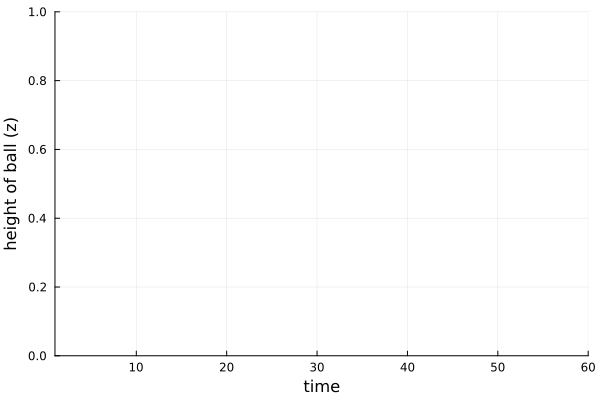

In [36]:
gif(animate_traces(result), fps=24)

Recall the inference task, we wanted to infer the mass and restitution of the object given the series of noisy position observations. 

Let's look at the marginal of each latent - that is the distribution of restitution considering any value of mass, and vice-versa. 

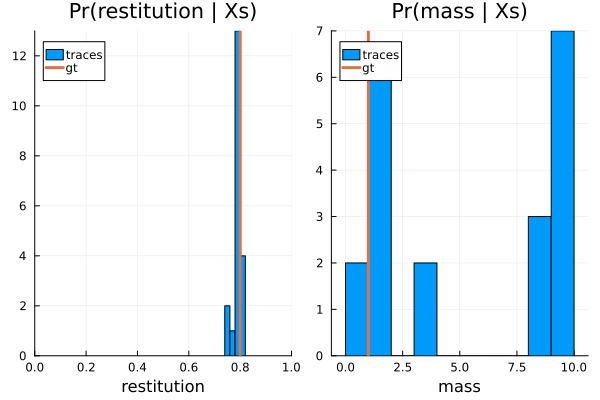

In [37]:
function get_latents(traces::Vector{<:Gen.Trace})
    n = length(traces)
    mass = Vector{Float64}(undef, n)
    restitution = Vector{Float64}(undef, n)
    for i = 1:n
        mass[i] = traces[i][:latents => 1 => :mass]
        restitution[i] = traces[i][:latents => 1 => :restitution]
    end
    (mass, restitution)
end
	
function plot_latents(traces::Vector{<:Gen.Trace}; gt_mass = 1.0,
                     gt_res = 0.8)
    mass, restitution = get_latents(traces)
    res_plt = histogram(
        restitution, title="Pr(restitution | Xs)", 
        xlabel="restitution", label="traces",
        xlims = (0., 1.0),
        bins=3
    )
    vline!(res_plt, [gt_res], label = "gt", linewidth=3) 
    mass_plt = histogram(
        mass, title="Pr(mass | Xs)",
        xlabel="mass", bins=10, label="traces"
    )
    vline!(mass_plt, [gt_mass], label = "gt", linewidth=3) 
    return plot(res_plt, mass_plt)
end

plot_latents(result)

Note how resitution is almost dead on the ground truth (0.8), whereas mass is all over the place (the ground truth was 1.0). 

Why is this the case? (Discuss amongst yourselves)

## Comparing two scenes

Ok, we inferred a posterior distribution over physical latents for the first scene - let's now do the same for the second. As a reminder, here is the trajecotory for the second scene.

[ Info: Saved animation to /home/psyc2610_meb266/Algorithms-of-the-Mind/labs/lab-06/tmp.gif


Plots.AnimatedGif("/home/psyc2610_meb266/Algorithms-of-the-Mind/labs/lab-06/tmp.gif")
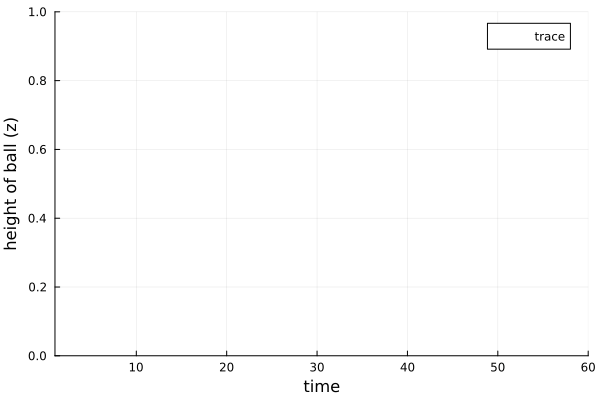

In [38]:
# First, let's generate a scene with a specific mass and restitution 
# Our goal is to generate a simulated observation that we can work with
gt_latents2 = choicemap(
    (:latents => 1 => :restitution, 0.5), 
    (:latents => 1 => :mass, 1.0)
)
gt2 = first(generate(model, gargs, gt_latents2));
gt_choices2 = get_choices(gt2)
    
# one set of observations per time step
# (notice that these do not contain gt latents)
observations2 = Vector{Gen.ChoiceMap}(undef, t)
for i = 1:t
    cm = choicemap()
    addr = :states => i => :positions
    set_submap!(cm, addr, get_submap(gt_choices2, addr))
    observations2[i] = cm
end

gif(animate_trace(gt2), fps=24)

In [39]:
result2 = inference_procedure(gargs, observations2); #should take a 5-15 seconds

And here are the results of inference...

[ Info: Saved animation to /home/psyc2610_meb266/Algorithms-of-the-Mind/labs/lab-06/tmp.gif


Plots.AnimatedGif("/home/psyc2610_meb266/Algorithms-of-the-Mind/labs/lab-06/tmp.gif")
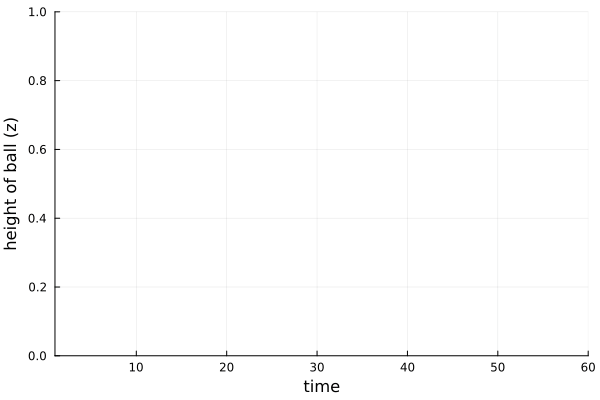

In [40]:
gif(animate_traces(result2), fps=24)

Looking at the ratio of Sim 1 / Sim 2, we see that the model would be very certain that the ball in the firt simulation is more bouncy than the ball in the second simulation.

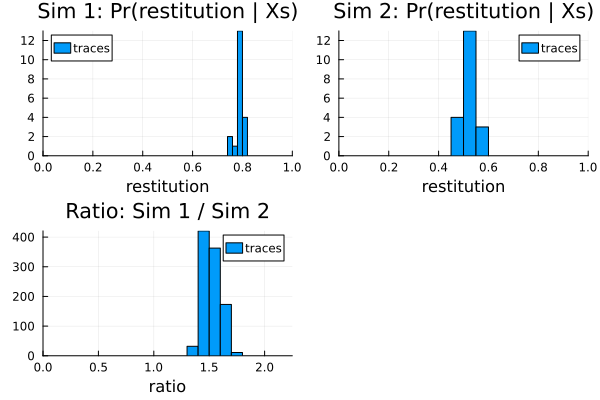

In [41]:
function bootstrap_ratio(latent1, latent2, n = 1000)
    samples = Vector{Float64}(undef, n)
    for i = 1:n
        samples[i] = rand(latent1) / rand(latent2)
    end
    return samples
end

function compare_latents(sim1::Vector{<:Gen.Trace}, sim2::Vector{<:Gen.Trace})
        _, restitution1 = get_latents(sim1)
        _, restitution2 = get_latents(sim2)
        ratio = bootstrap_ratio(restitution1, restitution2)
        
        res_plt1 = histogram(
            restitution1, title="Sim 1: Pr(restitution | Xs)", 
            xlabel="restitution", label="traces",
            xlims = (0., 1.0),
            bins=3
        )
        res_plt2 = histogram(
            restitution2, title="Sim 2: Pr(restitution | Xs)", 
            xlabel="restitution", label="traces",
            xlims = (0., 1.0),
            bins=3
        )

        ratio_plt =  histogram(
            ratio, title="Ratio: Sim 1 / Sim 2", 
            xlabel="ratio", label="traces",
            xlims = (0., 2.25),
            bins=5
        )
        return plot(res_plt1, res_plt2, ratio_plt)
    end
    
    compare_latents(result, result2)

## Summary and Future Reading

You've coded a basic model that infers structure-preserving representations using probabilistic programming. You can continue your learning through the following resources.

* We encourage you to read the [Woven paper (Bi et al., 2025)](https://www.nature.com/articles/s41467-025-61458-x) and explore its [codebase](https://github.com/CNCLgithub/Woven).
* Explore the official [Gen tutorials](https://www.gen.dev/tutorials/).
* Explore lab sections of the [Algorithms of the Mind](https://github.com/CNCLgithub/Algorithms-of-the-Mind/tree/main/labs) course.

We also appreciate your feedback to make this tutorial better for its future editions. Please fill out [this form](https://docs.google.com/forms/d/e/1FAIpQLSeKgA1yWT9QLtD2EtJUgPyoD7I4yyV21r66KRCpeOmuJrO01w/viewform?usp=dialog) if you have a minute. 